# Homework 6

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

## ASTR 5900, Fall 2020, University of Oklahoma

### Neural Networks

Imagine a neural network that has already been trained to classify configurations of spins in a lattice as 1 of 2 magnetic phases: ferromagnetic or paramagnetic.  A training set was generated using Monte Carlo at a range of temperatures, and the target classifications were determined for samples generated at temperatures below or above the known critical temperature for the 2D ferromagnetic Ising model with Hamiltonian $$ H = -J\sum_{<i,j>} \sigma^z_i \sigma^z_j $$
where $\sigma^z_k = \{-1, 1 \}$ is the spin at site $k$ and the summation is over adjacent spin sites (share an edge).  This Hamiltonian says there is energy stored between adjacent sites with opposite spins.  Because of this, at low temperatures the spins collectively point in a single direction (either up or down).  As the temperature increases and crosses the critical temperature $T_C$, this behavior suddenly fades and the Ising system becomes disordered with an average magnetization of zero.

### Part A

It's time to generate data with the functions we just defined and apply it to the trained neural net.  As you know, a standard feed forward neural network is a series of layers of connected neurons that fire (or fractionally fire) based on the linear sum of weights and inputs from their respective previous layer.

The neural network in question has 3 layers: the 400 size input layer (because the input is an spin configuration on a $20 \times 20$ lattice), a hidden layer with 3 perceptrons, and an output layer of 2 perceptrons.  The weights (3 $\times $ 400 matrix) and bias (3 $\times $ 1 matrix) of the first layer are:

$$ W_1 = \frac{1}{N(1 + \epsilon)}
 \begin{pmatrix}
  1 & 1 & \cdots & 1 \\
  -1 & -1 & \cdots & -1 \\
  1 & 1 & \cdots & 1
 \end{pmatrix} \; \; \text{and} \; \; b_1 = \frac{1}{1+\epsilon} \begin{pmatrix}
  -1 \\
  -1 \\
  1
 \end{pmatrix}$$
 
 This actually works out to be $$ Wx + b = \frac{1}{1 + \epsilon}\begin{pmatrix}
  m(x) - \epsilon \\
  -m(x) - \epsilon \\
  m(x) + \epsilon
 \end{pmatrix}$$
 
 where $m(x) = \frac{1}{N}\sum_i \sigma^z_i$ is the total magnetization of configuration $x$.  A heaviside step function is applied to each of these elements because they are Perceptrons.
 
The output's weights and biases are:
$$ W_2 = 
 \begin{pmatrix}
  2 & 1 &  -1 \\
      -2 & -2 & 1
 \end{pmatrix} \; \; \text{and} \; \; b_2 =\begin{pmatrix}
  0 \\
    0
 \end{pmatrix}$$

The output features 2 neurons: one that fires if the input is in the cold, ferromagnetic state and the other if the input is in the warm, paramagnetic state.  Write a function that takes a spin configuration (-1's, 1's) and forward propagates that information through layers as precribed above.  That is, manually perform the matrix multiplication and non-linear activation functions until you get an output to 2 nodes.  Use a small but finite value for $\epsilon$.

Use the spin data from a previous homework, `spins.txt`, to determine the critical temperature of the 2D Ising model:
- For every temperature in the dataset, average the output of the final 2 neurons separately.
- Plot these 2 averages as a function of temperature.  At what temperature do these lines cross?  That is interpreted as the critical temperature.

### Answer:

I've performed the described instruction, averaging the output values accordingly. I've plotted those averages, and determined that the critical temperature is about 1.254 (K?). (You could also interpolate to get a more accurate value for the true overlap, but I just used the discrete temperature values given and picked the one that gave the least difference.)

In [2]:
fn = 'spins.txt'
data = np.loadtxt(fn)
T = data[:, 0]
spin = data[:, 1:]

In [3]:
eps = 1e-5
N = spin.shape[1]
n1 = 3

# setup layer 2 transformation
w1 = np.ones((N, n1)) @ np.diag([1, -1, 1])
w1 = w1.T / (N * (1 + eps))

b1 = np.array([-1, -1, 1]) / (1 + eps)

# setup layer 2 transformation (output)
w2 = np.array([
    [2, 1, -1],
    [-2, -2, 1]
])
b2 = np.zeros(2)

# network functionality
def propagate(X, w, b):
    '''Compute output of single perceptron.'''
    y = w @ X + b
    return np.heaviside(y, 0.5)

def full_propagation(X):
    '''Compute output of entire network.'''
    y1 = propagate(X, w1, b1)
    y2 = propagate(y1, w2, b2) 
    return y2

In [4]:
temps = np.array(list(set(T)))
temps.sort()   # I thought set() sorted but I guess not

def get_averages(temp):
    states = spin[T == temp]
    outputs = [full_propagation(state) for state in states]
    outputs = np.array(outputs)
    return outputs.mean(axis=0)

averages = np.array([get_averages(temp) for temp in temps])

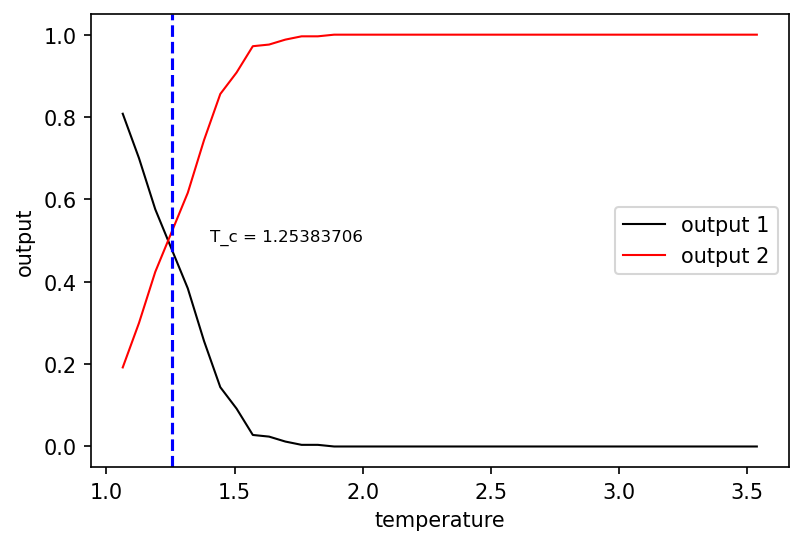

In [5]:
diffs = np.abs(averages[:, 1] - averages[:, 0])
Tc = temps[diffs.argmin()]

fig, ax = plt.subplots(dpi=150)

params = {'ls': '-', 'lw': 1, 'color': 'k', 'label': 'output 1'}
ax.plot(temps, averages[:, 0], **params)

params = {'ls': '-', 'lw': 1, 'color': 'r', 'label': 'output 2'}
ax.plot(temps, averages[:, 1], **params)

ax.axvline(Tc, ls='--', color='b')
ax.text(0.17, 0.5, f'T_c = {Tc}', transform=ax.transAxes, fontsize=8)

ax.set_xlabel('temperature')
ax.set_ylabel('output')

ax.legend()

plt.show()

### Part B

Train a neural network on conventional software (`sklearn.neural_network.MLPClassifier` or `tensorflow`) to classify spin states as either "ferromagnetic" or "paramagnetic".  Use the same `spins.txt` data to train and test your model (randomly split the data into 2 halves).  Evaluate the model's performance.

You will have to set the labels for the data yourselfs.  Temperatures above 2.269 should be classifed as paramagnetic, and temperatures below should be ferromagnetic.

### Answer:

I created the model in the same exact way (with default values and `Dense` layers) as the previous Try This exercise. After training the model on half the data and testing on the other data, we see that this model has about a 95.6% accuracy in determining whether a state gives a paramagnetic or ferromagnetic result based on the assumption about its corresponding temperature.

Looking at those states that were misclassified, most (~69%) of them seemed to be associated with higher temperatures (assumed as paramagnetic).

In [6]:
# create labels:
# True if paramagnetic, False if ferromagnetic
labels = T > 2.269

In [7]:
# create and compile model
n_outputs = 2
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(n_outputs)
])
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [8]:
# train the model
scale = StandardScaler()
scaled_data = scale.fit_transform(spin)
X_train, X_test, y_train, y_test = \
    train_test_split(scaled_data, labels,
                     test_size=0.5, random_state=42)

model.fit(X_train, y_train, epochs=10, verbose=0)

In [9]:
# test the model
test_loss, test_accuracy = model.evaluate(X_test,  y_test, verbose=2)

157/157 - 0s - loss: 0.1660 - accuracy: 0.9560


In [11]:
y_predict = np.argmax(model.predict(X_test), axis=-1)
missed_mask = (y_predict - y_test) != 0

missed_labels = y_test[missed_mask]
missed_para_frac = missed_labels.sum() / missed_mask.sum()

print(f'Percent of misclassified states being paramagnetic: {missed_para_frac:.2f}')
print(f'Percent of misclassified states being ferromagnetic: {1 - missed_para_frac:.2f}')

Percent of misclassified states being paramagnetic: 0.69
Percent of misclassified states being ferromagnetic: 0.31
